In [39]:
import pandas as pd
import numpy as np
import random
import math
import gc
import matplotlib.pylab as plt
import networkx as nx
from copy import deepcopy
import marshal
import sys

# Graph Initialization


In [40]:
random.seed(1)
num_vertices = 100
adjacency_matrix = np.zeros((num_vertices,num_vertices),dtype = np.int)

edge_probability = .0085 if num_vertices > 100 else 0.09

edges = []
edges_cnt = 0
for i in range(num_vertices):
    for j in range(i):
        prob = random.random()
        if prob < edge_probability:
            adjacency_matrix[i,j] = 1
            edges.append((i,j))
            edges_cnt += 1
            
adjacency_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [41]:
G=nx.Graph()
G.add_nodes_from(list(range(0,num_vertices)))
G.add_edges_from(edges)

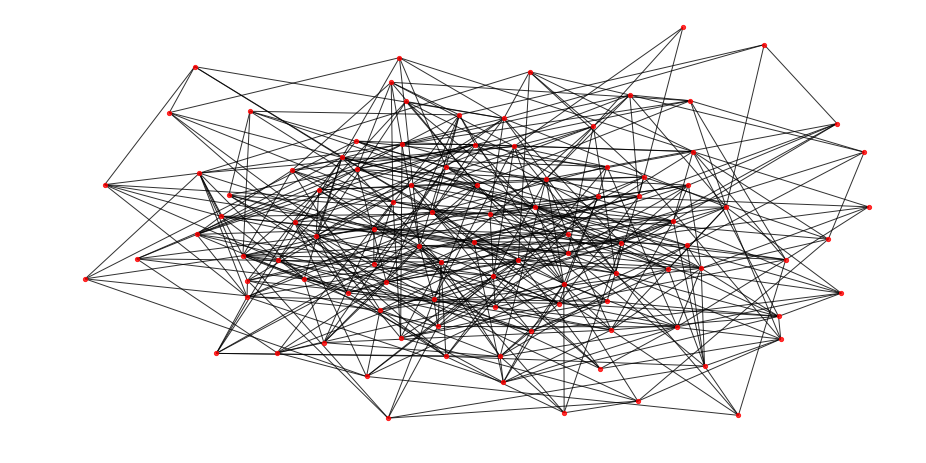

In [42]:
plt.figure(figsize=(12,6))
nx.draw(G,node_color='r', node_size=18, alpha=0.8)
plt.show() # display

In [43]:
vertex_weights = {node:1 for node in range(num_vertices)}

# Greedy algorithm

In [44]:
#Vertex Cover Greedy Algorithm
visited = np.zeros(num_vertices)
greedy_vertex_dict = {}
greedy_edges = deepcopy(edges)

for vertex in range(num_vertices):
    greedy_vertex_dict[vertex] = sum(adjacency_matrix[vertex])/vertex_weights[vertex]

greedy_vertex_dict_ordered = dict(sorted(greedy_vertex_dict.items(), key=lambda item: item[1], reverse=True))

greedy_count = 0
vcount = 0
for vertex in greedy_vertex_dict_ordered:
    to_remove = set()
    for edge in greedy_edges:
        if vertex in edge:
            to_remove.add(edge)
    for edge in to_remove:
        greedy_edges.remove(edge)
    greedy_count +=vertex_weights[vertex]
    vcount += 1
    if len(greedy_edges) == 0: 
        break

In [45]:
print("Vertex cover weight is {}".format(greedy_count))

Vertex cover weight is 93


In [46]:
approximation_algo_result = greedy_count
approximation_algo_result

93

# Genetic algorithm

In [47]:
# Init
num_vertices = num_vertices
total_population = 15 #Maximum population allowed in environment
population_init = 10
max_iterations = 50
overall_best_solution = None
overall_best_solution_fitness = sys.maxsize
num_generations = 50
cross_over_prob = 0.50
mutation_prob = 0.05

In [48]:
def generate_random_population(pop_size):
    global num_vertices

    population = []

    # Initializing population with strings full of zeros...
    for i in range(pop_size):
        population.append([0] * num_vertices)

    for solution in range(pop_size):
        for ind in range(num_vertices):

            # Generate a uniform random number between 0 and 1...
            random_number = random.uniform(0, 1)

            # If the random_number is greater than or equal to 0.5, we set that index to one...
            if random_number >= 0.5:
                population[solution][ind] = 1

    return population

In [49]:
def check_solution(solution, new_adjacency_matrix, for_special_index):
    global num_vertices

    # We have two cases, if for_special_index is None, we will look for all included vertices...
    if for_special_index is None:
        # We will convert all edges from one to zero for each included vertex...
        for row in range(num_vertices):
            # If that vertex is not included, move on...
            if solution[row] == 0:
                continue

            # Loop the row...
            for i in range(num_vertices):
                new_adjacency_matrix[row][i] = 0
            # Loop the column...
            for i in range(num_vertices):
                new_adjacency_matrix[i][row] = 0

    # Otherwise, we will look for just that index number...
    else:
        # Loop the row...
        for i in range(num_vertices):
            new_adjacency_matrix[for_special_index][i] = 0
        # Loop the column...
        for i in range(num_vertices):
            new_adjacency_matrix[i][for_special_index] = 0
    # Lastly, we will check if adjacency matrix contains ones...
    if any(1 in i for i in new_adjacency_matrix):
        return False

    return True

In [50]:
def repair_population(pop_size, population):
    global num_vertices, adjacency_matrix

    # We will check each solution...
    for i in range(pop_size):

        # Creating a new adjacency matrix for a faster usage...
        new_adjacency_matrix = deepcopy(adjacency_matrix)
        for_special_index = None

        # While this solution is not feasible, try to make it feasible...
        while not check_solution(population[i], new_adjacency_matrix, for_special_index):

            # Generate a uniform random number between 0 and num_vertices...
            available_vertices_indices = [ind for ind in range(num_vertices) if population[i][ind] == 0]
            random_number = random.choice(available_vertices_indices)
            # When we found an index that is zero, we change it to one...
            for_special_index = int(random_number)
            population[i][for_special_index] = 1

In [51]:
def calculate_fitness_value(solution):
    global num_vertices, vertex_weights

    weight_sum = 0.0
    for i in range(num_vertices):

        # If that vertex is not included, move on...
        if solution[i] == 0:
            continue

        weight_sum += vertex_weights[i]

    return weight_sum

In [52]:
def construct_mating_pool(pop_size, population):
    mating_pool = []

    for i in range(pop_size):

        # Generate two uniform random number between 0 and pop_size...
        random_number_1 = random.uniform(0, pop_size)
        random_number_2 = random.uniform(0, pop_size)

        # Get those two solutions from population...
        solution_1 = population[int(random_number_1)]
        solution_2 = population[int(random_number_2)]

        # Calculate the fitness values for these solutions...
        fitness_1 = calculate_fitness_value(solution_1)
        fitness_2 = calculate_fitness_value(solution_2)

        # For this problem, a better fitness value is the smaller one because it contains fewer vertices...
        if fitness_1 < fitness_2:
            mating_pool.append(solution_1)
        else:
            mating_pool.append(solution_2)

    return mating_pool



In [53]:
def crossover_population(pop_size, crossover_prob, mating_pool):
    global num_vertices
    population = []

    for i in range(int(pop_size / 2)):

        # Generate a uniform random number between 0 and 1...
        random_number = random.uniform(0, 1)

        # If the random number is less than or equal to the crossover_prob, we will do crossover...
        if random_number <= crossover_prob:

            # Generate a uniform random number between 0 and num_vertices...
            random_number = int(random.uniform(0, num_vertices))

            # Then, get the string till the index number from the first solution, and the rest from the second...
            # And, the reverse for a second solution...
            new_solution_1 = mating_pool[i*2][:random_number] + mating_pool[i*2 + 1][random_number:]
            new_solution_2 = mating_pool[i*2 + 1][:random_number] + mating_pool[i*2][random_number:]

            # Append to population list...
            population.append(new_solution_1)
            population.append(new_solution_2)

        # Else, we will pass two parents onto the next generation...
        else:
            population.append(mating_pool[i*2])
            population.append(mating_pool[i*2 + 1])
            
    return population

In [54]:
def mutate_population(pop_size, mutation_prob, population):
    global num_vertices

    # We will check each solution...
    for i in range(pop_size):
        # We will generate a random number for each bit of the string...
        for j in range(num_vertices):

            # Generate a uniform random number between 0 and 1...
            random_number = random.uniform(0, 1)

            # If the random number is less than or equal to the mutation_prob, we will do mutation...
            if random_number <= mutation_prob:
                population[i][j] = (population[i][j] + 1)%2 

In [55]:
def calc_best_solutions(population):
    global overall_best_solution_fitness, overall_best_solution

    best_solution = None
    best_solution_fitness = sys.maxsize
    overall_solution_fitness = 0
    worst_solution_fitness = 0

    for pop in population:

        fitness = calculate_fitness_value(pop)

        # Checking the best solution...
        if fitness < best_solution_fitness:
            best_solution = pop
            best_solution_fitness = fitness

        # Checking the worst solution fitness...
        if fitness > worst_solution_fitness:
            worst_solution_fitness = fitness

        # Adding to overall fitness...
        overall_solution_fitness += fitness

    # Before printing the results, we should update the overall best solution...
    if best_solution_fitness < overall_best_solution_fitness:
        overall_best_solution_fitness = best_solution_fitness
        overall_best_solution = deepcopy(best_solution)
        
    return overall_best_solution

In [56]:
population = generate_random_population(total_population)
# Run the algorithm for given number of generations...
for current_generation in range(num_generations*2):

    # Construct mating pool using binary tournament selection...
    mating_pool = construct_mating_pool(total_population, population)

    # Shuffling the mating pool...
    random.shuffle(mating_pool)

    # Crossover population with given probability...
    population_temp = crossover_population(total_population, cross_over_prob, mating_pool)
    if total_population%2 == 1:
        population_temp.append(population[random.choice(range(total_population))])
        
    population = population_temp
    # Mutating population with given probability...
    mutate_population(total_population, mutation_prob, population)

    # Repairing infeasible solutions...
    repair_population(total_population, population)
    
    overall_best_solution = calc_best_solutions(population)

    # After all generations complete, we print overall best solution...
    print(current_generation)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


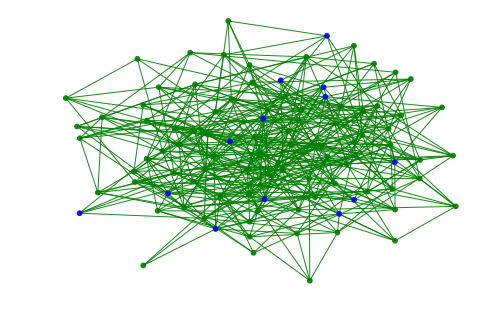

1.0
Genetic: 87, Greedy Algorithm: 93


In [57]:
color_map = []

for node in G:
    if overall_best_solution[node] == 1:
        color_map.append('green')
    else: 
        color_map.append('blue')      

edge_colours = []
for (u,v) in G.edges():
    if overall_best_solution[u] == 1 or overall_best_solution[v] == 1:
        edge_colours.append("green")
    else:
        edge_colours.append("red")
        
nx.draw(G, node_color=color_map, edge_color=edge_colours, node_size=22, alpha=0.9)
plt.show()

edges_visited = 0
for col in edge_colours:
    if col == "green":
        edges_visited+=1
print(edges_visited/len(edge_colours))
genetic_cost = 0
for vertex,val in enumerate(overall_best_solution):
    if val==1:
        genetic_cost += vertex_weights[vertex]
print(f"Genetic: {genetic_cost}, Greedy Algorithm: {greedy_count}")